In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm
import json, os
from pathlib import Path
from torchvision import models
import numpy as np
import cv2
import torchvision.transforms as T
from torchvision.transforms import v2
import random
import torchvision.models.video as video_models
from decord import VideoReader, cpu

In [10]:
def sample_frames(video, num_frames=16):
    T = video.size(0)

    if T >= num_frames:
        # uniform temporal sampling
        indices = torch.linspace(0, T-1, num_frames).long()
        clip = video[indices]
    else:
        # pad last frame
        pad = num_frames - T
        last = video[-1].unsqueeze(0).repeat(pad, 1, 1, 1)
        clip = torch.cat([video, last], dim=0)

    return clip

In [32]:
class VideoClipDataset(Dataset):
    def __init__(self, clips_json_path, num_frames=16, transform=None):
        self.samples = json.load(open(clips_json_path))
        self.num_frames = num_frames
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        item = self.samples[idx]
        video_path = Path(item["video"])

        # =============================
        # LOAD VIDEO WITH DECORD
        # =============================
        vr = VideoReader(str(video_path), ctx=cpu())
        total_frames = len(vr)

        # get all frames as a tensor (T, H, W, C)
        video = vr.get_batch(range(total_frames)).asnumpy()
        video = torch.from_numpy(video).float() / 255.0
        # video shape = (T, H, W, C)

        # =============================
        # SAMPLE FRAMES (unchanged)
        # =============================
        clip = sample_frames(video, self.num_frames)

        # (T, H, W, C) → (C, T, H, W)
        clip = clip.permute(3, 0, 1, 2)

        # =============================
        # TRANSFORMS PER FRAME
        # =============================
        if self.transform:
            clip = torch.stack([
                self.transform(frame) 
                for frame in clip.permute(1,0,2,3)
            ]).permute(1,0,2,3)

        label = torch.tensor(item["highlight"], dtype=torch.float32)
        return clip, label


In [33]:
video_train_transform = T.Compose([
    T.Resize((256, 256)),
    T.RandomCrop((224, 224)),
    T.RandomHorizontalFlip(p=0.5),

    # color jitter (team jersey robustness)
    T.ColorJitter(
        brightness=0.4,
        contrast=0.4,
        saturation=0.4,
        hue=0.1
    ),

    # sometimes grayscale (team colors vary)
    T.RandomGrayscale(p=0.2),

    # IMPORTANT: Normalize for ResNet3D (Kinetics-400)
    T.Normalize(
        mean=[0.43216, 0.394666, 0.37645],
        std=[0.22803, 0.22145, 0.216989]
    )
])

video_val_transform = T.Compose([
    T.Resize((224, 224)),
    T.Normalize(
        mean=[0.43216, 0.394666, 0.37645],
        std=[0.22803, 0.22145, 0.216989]
    )
])


In [34]:
train_dataset = VideoClipDataset("data/train/clips.json", transform=video_train_transform)
val_dataset   = VideoClipDataset("data/val/clips.json",   transform=video_val_transform)
test_dataset  = VideoClipDataset("data/test/clips.json",  transform=video_val_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
val_loader   = torch.utils.data.DataLoader(val_dataset,   batch_size=4, num_workers=0)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size=4, num_workers=0)

In [25]:
class VideoResNet3D(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = video_models.r3d_18(weights="DEFAULT")
        self.model.fc = nn.Linear(512, 1)  # binary classification

    def forward(self, x):
        return self.model(x).squeeze(1)

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

EPOCHS = 10
model = VideoResNet3D().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

In [35]:
import os
os.makedirs("video_checkpoints", exist_ok=True)

history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
}

best_val_acc = 0.0

for epoch in range(EPOCHS):
    # =================================================
    # TRAINING
    # =================================================
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} - Training", leave=True)
    for video, label in pbar:
        video, label = video.to(device), label.to(device)

        optimizer.zero_grad()
        logits = model(video)
        loss = criterion(logits, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
        optimizer.step()

        train_loss += loss.item() * video.size(0)

        preds = (torch.sigmoid(logits) > 0.5).float()
        correct += (preds.cpu() == label.cpu()).sum().item()
        total += label.size(0)

        pbar.set_postfix({"loss": loss.item()})

    train_loss /= len(train_loader.dataset)
    train_acc = correct / total

    # =================================================
    # VALIDATION
    # =================================================
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} - Validating", leave=True)
    with torch.no_grad():
        for video, label in pbar:
            video, label = video.to(device), label.to(device)

            logits = model(video)
            loss = criterion(logits, label)

            preds = (torch.sigmoid(logits) > 0.5).float()
            val_correct += (preds.cpu() == label.cpu()).sum().item()
            val_total += label.size(0)

            val_loss += loss.item() * video.size(0)
            pbar.set_postfix({"loss": loss.item()})

    val_loss /= len(val_loader.dataset)
    val_acc = val_correct / val_total

    # =================================================
    # STORE HISTORY
    # =================================================
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    # =================================================
    # PRINT SUMMARY
    # =================================================
    print(f"\nEpoch {epoch+1}/{EPOCHS} Results:")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

    # =================================================
    # SAVE BEST CHECKPOINT
    # =================================================
    checkpoint = {
        "epoch": epoch + 1,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "scheduler_state": scheduler.state_dict(),
        "train_loss": train_loss,
        "train_acc": train_acc,
        "val_loss": val_loss,
        "val_acc": val_acc,
    }

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(checkpoint, "video_checkpoints/video_model.pt")
        print("🔥 New best video model saved!")
    
    # =================================================
    # SCHEDULER STEP
    # =================================================
    scheduler.step()

print("\nTraining complete!")

Epoch 1/10 - Validating: 100%|██████████| 166/166 [01:44<00:00,  1.59it/s, loss=0.165] 



Epoch 1/10 Results:
Train Loss: 0.3716 | Train Acc: 0.8399
Val Loss:   0.3605 | Val Acc:   0.8554
Learning Rate: 0.000100
🔥 New best video model saved!


Epoch 2/10 - Validating: 100%|██████████| 166/166 [01:39<00:00,  1.66it/s, loss=0.0978]



Epoch 2/10 Results:
Train Loss: 0.3101 | Train Acc: 0.8666
Val Loss:   0.3296 | Val Acc:   0.8479
Learning Rate: 0.000098


Epoch 3/10 - Validating: 100%|██████████| 166/166 [01:41<00:00,  1.63it/s, loss=0.0228] 



Epoch 3/10 Results:
Train Loss: 0.2837 | Train Acc: 0.8846
Val Loss:   0.3578 | Val Acc:   0.8343
Learning Rate: 0.000090


Epoch 4/10 - Validating: 100%|██████████| 166/166 [01:38<00:00,  1.69it/s, loss=0.0478]



Epoch 4/10 Results:
Train Loss: 0.2687 | Train Acc: 0.8930
Val Loss:   0.3229 | Val Acc:   0.8509
Learning Rate: 0.000079


Epoch 5/10 - Validating: 100%|██████████| 166/166 [01:37<00:00,  1.70it/s, loss=0.0434] 



Epoch 5/10 Results:
Train Loss: 0.2402 | Train Acc: 0.8959
Val Loss:   0.3036 | Val Acc:   0.8645
Learning Rate: 0.000065
🔥 New best video model saved!


Epoch 6/10 - Validating: 100%|██████████| 166/166 [01:37<00:00,  1.70it/s, loss=0.00323]



Epoch 6/10 Results:
Train Loss: 0.2238 | Train Acc: 0.9119
Val Loss:   0.3829 | Val Acc:   0.8389
Learning Rate: 0.000050


Epoch 7/10 - Validating: 100%|██████████| 166/166 [01:37<00:00,  1.71it/s, loss=0.00481]



Epoch 7/10 Results:
Train Loss: 0.2039 | Train Acc: 0.9151
Val Loss:   0.3245 | Val Acc:   0.8569
Learning Rate: 0.000035


Epoch 8/10 - Validating: 100%|██████████| 166/166 [01:37<00:00,  1.70it/s, loss=0.00153] 



Epoch 8/10 Results:
Train Loss: 0.1770 | Train Acc: 0.9283
Val Loss:   0.3573 | Val Acc:   0.8645
Learning Rate: 0.000021


Epoch 9/10 - Validating: 100%|██████████| 166/166 [01:35<00:00,  1.73it/s, loss=0.00309]



Epoch 9/10 Results:
Train Loss: 0.1540 | Train Acc: 0.9376
Val Loss:   0.3669 | Val Acc:   0.8539
Learning Rate: 0.000010


Epoch 10/10 - Validating: 100%|██████████| 166/166 [01:37<00:00,  1.71it/s, loss=0.0013] 


Epoch 10/10 Results:
Train Loss: 0.1402 | Train Acc: 0.9437
Val Loss:   0.3889 | Val Acc:   0.8630
Learning Rate: 0.000002

Training complete!


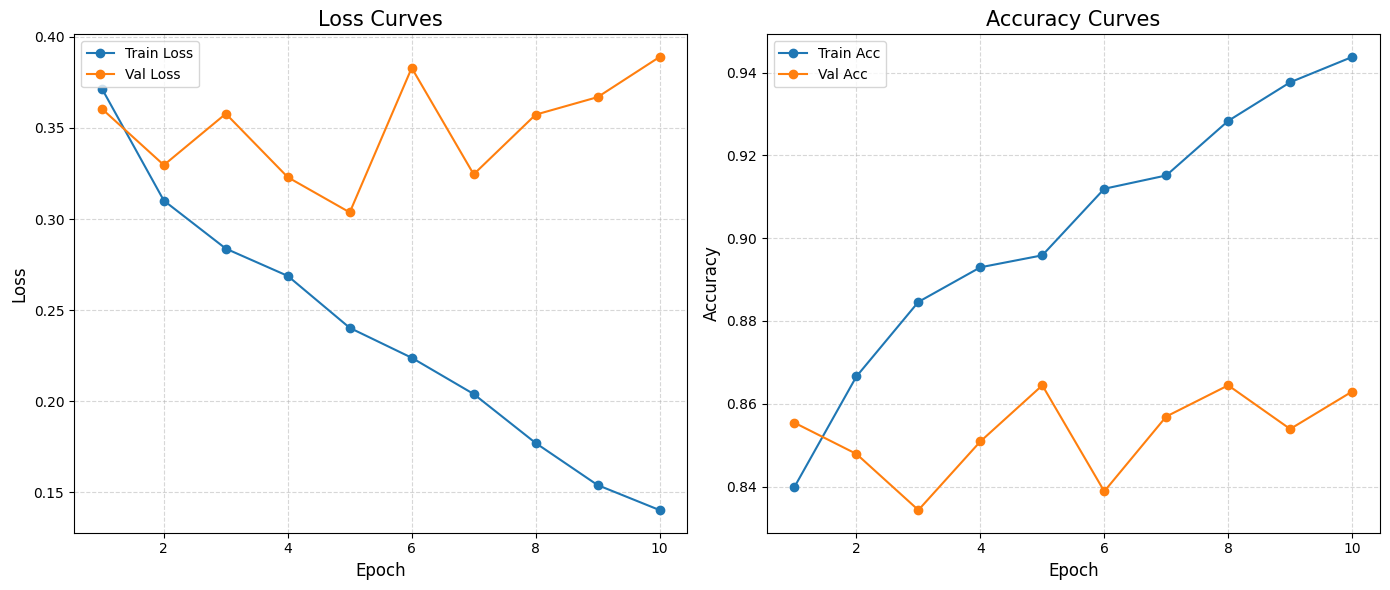

In [36]:
import matplotlib.pyplot as plt

epochs = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(14, 6))

# ==========================
# LOSS
# ==========================
plt.subplot(1, 2, 1)
plt.plot(epochs, history["train_loss"], label="Train Loss", marker="o")
plt.plot(epochs, history["val_loss"], label="Val Loss", marker="o")
plt.title("Loss Curves", fontsize=15)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()

# ==========================
# ACCURACY
# ==========================
plt.subplot(1, 2, 2)
plt.plot(epochs, history["train_acc"], label="Train Acc", marker="o")
plt.plot(epochs, history["val_acc"], label="Val Acc", marker="o")
plt.title("Accuracy Curves", fontsize=15)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()

plt.tight_layout()
plt.show()


In [37]:
@torch.no_grad()
def eval_on_test(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    pbar = tqdm(test_loader, desc="Testing", leave=True)

    for mel, label in pbar:
        mel, label = mel.to(device), label.to(device)

        logits = model(mel)
        loss = criterion(logits, label)

        preds = (torch.sigmoid(logits) > 0.5).float()

        correct += (preds.cpu() == label.cpu()).sum().item()
        total += label.size(0)
        total_loss += loss.item() * mel.size(0)

        pbar.set_postfix({"loss": loss.item()})

    test_loss = total_loss / len(test_loader.dataset)
    test_acc = correct / total

    return test_loss, test_acc


In [38]:
# Load best model checkpoint
checkpoint = torch.load("video_checkpoints/video_model.pt", map_location=device)

model.load_state_dict(checkpoint["model_state"])
scheduler.load_state_dict(checkpoint["scheduler_state"])  # Optional

print("Loaded best model!")

test_loss, test_acc = eval_on_test(model, test_loader, criterion, device)

print("\n===== TEST RESULTS =====")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Acc:  {test_acc:.4f}")


Loaded best model!


Testing: 100%|██████████| 195/195 [01:59<00:00,  1.63it/s, loss=0.102]  


===== TEST RESULTS =====
Test Loss: 0.2822
Test Acc:  0.8687
